# Section 1. Preparing the Data

### 1.1. Loading required passages (TensorFlow, NumPy, Pandas, CV2)

Importing needed packages.

**Essential Note:**
If you would like to test _Keras Facenet Feature Extraction_ which I use here, you should use older versions of _Keras_, _TensorFlow_, and probably _Python_ as well. 

**My configuration of kernel for Keras Facenet:**
- TensorFlow: 1.14.0
- Keras: 2.3.1
- Python: 3.6.2

_P.S. That was quite painful to find this configuration and avoid all the conflicts :D_

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow image preprocessing 
from tensorflow.keras.preprocessing import image as image_preprocessing
import tensorflow.keras.backend as tf_backend 
tf_backend.set_image_data_format('channels_last')

# Importing fetch_lfw_people dataset from the sklearn.datasets package
from sklearn.datasets import fetch_lfw_people

# Import all other needed packages
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import face_recognition
import glob
from PIL import Image

# Internal helper imports
from helpers import graphics as help_graph
from helpers import binary_converter as help_binary
from helpers import accuracy_calculator as help_calc
from helpers import shaper as help_shaper
from helpers import vector_extractor as help_extract
from helpers import segmenter as help_segmenter

%matplotlib inline

Using TensorFlow backend.


### 1.2. Loading images dataset for checking the accuracy

Note, that if you are trying to run this notebook, run only one block from either **Option 1** or **Option 2**.

**Option 1.** Importing `fetch_lfw_people` dataset from `sklearn.datasets`

In [ ]:
# Importing dataset
lfw_people_dataset = fetch_lfw_people(min_faces_per_person=80, color=True)

# Settings images
people_images = lfw_people_dataset.images
# Setting labels
people_labels = lfw_people_dataset.target

**Option 2**. Importing `lfw` [dataset](http://vis-www.cs.umass.edu/lfw/) from the folder

In [2]:
# Specifying path to the images
lfw_dataset_path = './Images/lfw'
# Getting array of subpaths
lfw_people_subpaths = [subdirectory[0] for subdirectory in os.walk(lfw_dataset_path)]
# Setting minimal amount of faces needed for one person
faces_per_person = 30

people_images, people_labels = [], []

# Going along the array
for person_id, subpath in enumerate(lfw_people_subpaths[1:]):
    subpath_images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob(subpath + '/*.jpg')]
    if len(subpath_images) < faces_per_person:
        continue

    for image in subpath_images[:faces_per_person]:
        people_images.append(image)
    
    people_labels += [person_id] * faces_per_person
    
# Checking if loading was completed
print(np.shape(people_images))

(1020, 250, 250, 3)


Converting `lfw_people` and `lfw_people_labels` to the np array 

In [3]:
people_images_np = np.array(people_images, dtype = float)
print('Shape of images dataset:', people_images_np.shape)

Shape of images dataset: (1020, 250, 250, 3)


Displaying the dataset to check whether we initialized everything properly

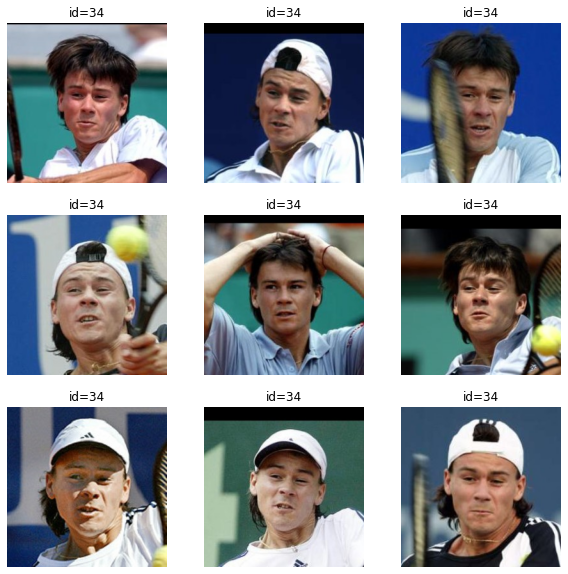

In [4]:
gallery_offset = 0 # Can be changed to "move" the gallery
gallery_width = 3 # Can be changed to resize gallery

help_graph.display_images(
    people_images_np[(gallery_offset):(gallery_width**2 + gallery_offset)], 
    people_labels[(gallery_offset):(gallery_width**2 + gallery_offset)])

### 1.3. Forming batches of images of the same person

Batch shape (30, 250, 250, 3)


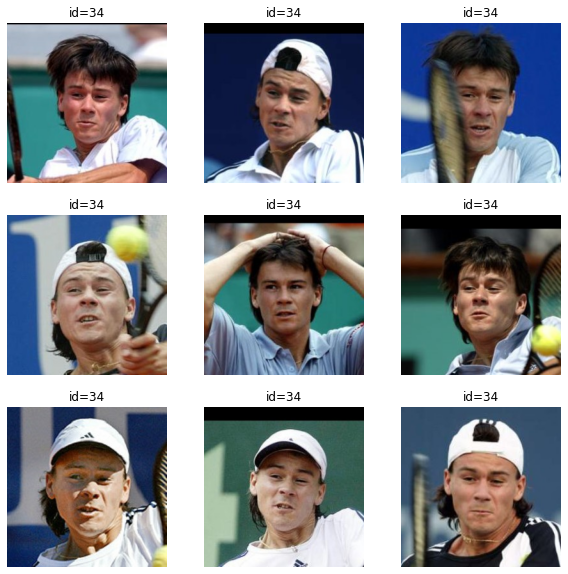

In [5]:
person_id = 34 # Person's ID to be displayed
batch = help_shaper.form_batch_by_id(people_images_np, people_labels, image_id=person_id) # Getting images of a person

print('Batch shape', batch.shape) # Check whether the shape is correct

# Displaying a gallery
help_graph.display_images(
    batch[:(gallery_width**2)], 
    np.full((gallery_width**2), person_id, dtype=int), 
    gallery_size=3)

Number of batches: 34
Shape of selected batch: (30, 250, 250, 3)
Shape of numpy list of batches: (34, 30, 250, 250, 3)


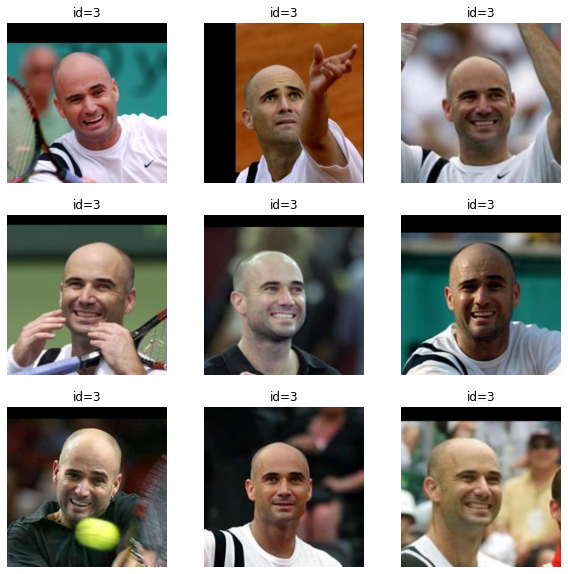

In [6]:
# Distributing images into batches of the same id
image_batches = help_shaper.form_batches_list(people_images_np, people_labels)
# Id of a batch to display in the gallery
image_batch_display_id = 3

# Trying to use form_batches_numpy
image_batches_numpy = help_shaper.form_batches_numpy(image_batches, 
                                                     people_labels, dataset='local_lfw_people')

# Displaying a gallery
help_graph.display_images(
    image_batches_numpy[image_batch_display_id][:(gallery_width**2)], 
    np.full((gallery_width**2), image_batch_display_id, dtype=int), 
    gallery_size=3)

# Printing some info to verify that everything was implemented properly
print('Number of batches:', len(image_batches))
print('Shape of selected batch:', image_batches[image_batch_display_id].shape)
print('Shape of numpy list of batches:', image_batches_numpy.shape)

# Section 2. Extracting features from an image using Keras Facenet

#### Loading model's weights and model itself

In [7]:
model = keras.models.load_model('models/facenet_keras.h5', compile=False)

Using FaceNet, we can extract a feature vector of dimension $n_f$ from a given image $I$, that is:
$$
\mathbf{f}(I) = \begin{pmatrix} f(I)_1 \\ f(I)_2 \\ \vdots \\ f(I)_{n_f} \end{pmatrix}
$$
To evaluate difference $d(I, J)$ between images $I$ and $J$ we are going to simply take a square of the feature-vectors difference norm:
$$
d(I, J) = \left(\mathbf{f}(I) - \mathbf{f}(J)\right)^T\left(\mathbf{f}(I) - \mathbf{f}(J)\right)(\mathbf{f}(I^{(m)}) - \mathbf{f}(I^{(k)}))(\mathbf{f}(I^{(m)}) - \mathbf{f}(I^{(k)})) = \sum_{j=1}^{n_f} (f(I)_j - f(J)_j)^2
$$

### Section 2.1 (Optinal). Segmenting face from the picture

In [9]:
# Segmenting batches (OPTIONAL)
image_batches_segmented = help_segmenter.segment_batches(image_batches)

Trying to load batch #0...
Trying to load batch #1...
Trying to load batch #2...
Trying to load batch #3...
Trying to load batch #4...
Trying to load batch #5...
Trying to load batch #6...
Trying to load batch #7...
Trying to load batch #8...
Trying to load batch #9...
Trying to load batch #10...
Trying to load batch #11...
Trying to load batch #12...
Trying to load batch #13...
Trying to load batch #14...
Trying to load batch #15...
Trying to load batch #16...
Trying to load batch #17...
Trying to load batch #18...
Trying to load batch #19...
Trying to load batch #20...
Trying to load batch #21...
Trying to load batch #22...
Trying to load batch #23...
Trying to load batch #24...
Trying to load batch #25...
Trying to load batch #26...
Trying to load batch #27...
Trying to load batch #28...
Trying to load batch #29...
Trying to load batch #30...
Trying to load batch #31...
Trying to load batch #32...
Trying to load batch #33...


Normalized batches array shape (34, 28)


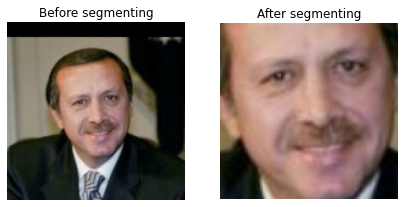

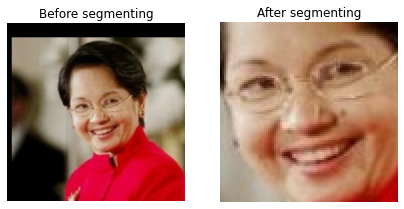

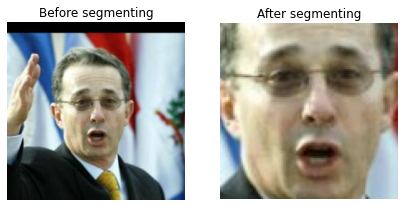

In [10]:
image_batches_segmented_np = help_shaper.normalize_batches_size(image_batches_segmented)
print('Normalized batches array shape', np.shape(image_batches_segmented_np))

help_graph.visualize_segmented(image_batches[4][3], image_batches_segmented_np[4][3], figure_size=7)
help_graph.visualize_segmented(image_batches[1][10], image_batches_segmented_np[1][10], figure_size=7)
help_graph.visualize_segmented(image_batches[2][20], image_batches_segmented_np[2][20], figure_size=7)

**Note!** This line will overwrite the previously formed array `image_batches_numpy`

In [11]:
# Updating image_batches_numpy
image_batches_numpy = image_batches_segmented_np

### Section 2.2. Retrieving the set of features for our images

**Distance between vectors function**

In [12]:
# Getting array of feature vectors
feature_vectors = help_extract.extract_vectors_from_batches(image_batches_numpy, model=model)

Loading batch #0...
Successfully processed batch #0

Loading batch #1...
Successfully processed batch #1
Loading batch #2...
Successfully processed batch #2
Loading batch #3...
Successfully processed batch #3
Loading batch #4...
Successfully processed batch #4
Loading batch #5...
Successfully processed batch #5
Loading batch #6...
Successfully processed batch #6
Loading batch #7...
Successfully processed batch #7
Loading batch #8...
Successfully processed batch #8
Loading batch #9...
Successfully processed batch #9
Loading batch #10...
Successfully processed batch #10
Loading batch #11...
Successfully processed batch #11
Loading batch #12...
Successfully processed batch #12
Loading batch #13...
Successfully processed batch #13
Loading batch #14...
Successfully processed batch #14
Loading batch #15...
Successfully processed batch #15
Loading batch #16...
Successfully processed batch #16
Loading batch #17...
Successfully processed batch #17
Loading batch #18...
Successfully processed bat

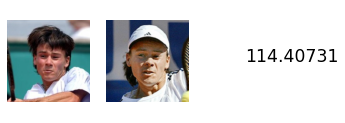

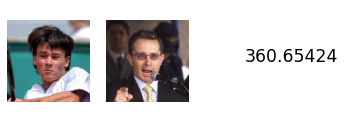

In [13]:
n1, i1, k1, j1 = 0, 0, 0, 6
n2, i2, k2, j2 = 0, 0, 2, 15


help_graph.distance_visualize(image_batches[n1][i1], 
                   image_batches[k1][j1], 
                   help_extract.feature_vectors_distance(feature_vectors[n1][i1], feature_vectors[k1][j1]))
help_graph.distance_visualize(image_batches[n2][i2], 
                   image_batches[k2][j2],
                   help_extract.feature_vectors_distance(feature_vectors[n2][i2], feature_vectors[k2][j2]))

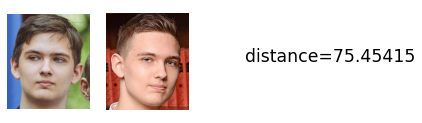

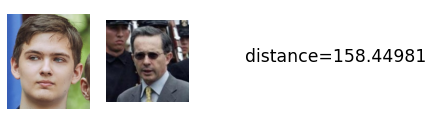

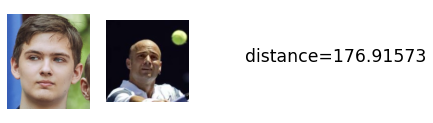

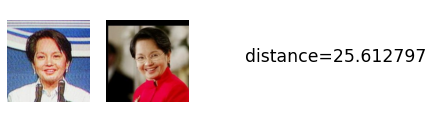

In [14]:
# Read images
person_1 = np.array(Image.open('Images/Dima1.png'))
person_2 = np.array(Image.open('Images/Dima2.png'))

# Visualization of all distances
help_graph.distance_visualize(person_1, person_2, help_extract.get_distance_between_images(person_1, person_2, model), 'distance')
help_graph.distance_visualize(person_1, image_batches[2][3], help_extract.get_distance_between_images(person_1, image_batches[2][3], model), 'distance')
help_graph.distance_visualize(person_1, image_batches[3][10], help_extract.get_distance_between_images(person_1, image_batches[3][10], model), 'distance')
help_graph.distance_visualize(image_batches[1][15], 
                   image_batches[1][10], 
                   help_extract.get_distance_between_images(image_batches[1][15], image_batches[1][10], model), 'distance')

# Section 3. Estimating the accuracy

### 3.1. Forming set of pairs

In [15]:
# Forming a list of pairs
pairs = help_shaper.form_pairs_list((len(feature_vectors), help_shaper.get_minimal_batch_size(feature_vectors)))

### 3.2. Finding the best threshold to estimate pair difference

In [16]:
# Getting arrays of threshold and accuracies
thresholds, accuracies = help_calc.threshold_accuracies(pairs, feature_vectors, lower_edge=40.0, upper_edge=300.0, step=0.01)

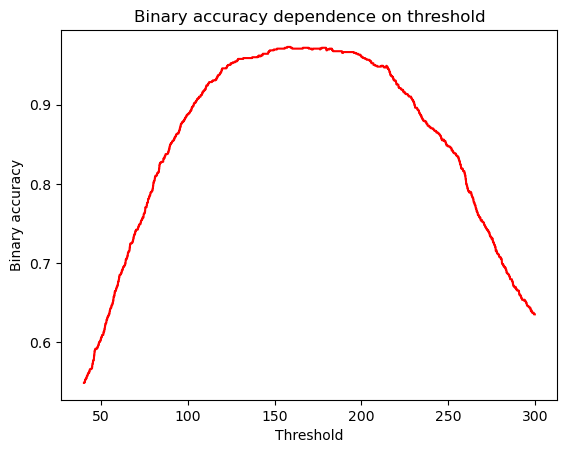

In [17]:
help_graph.draw_plot(thresholds, accuracies,
                     X_label='Threshold', Y_label='Binary accuracy', 
                     title='Binary accuracy dependence on threshold', color='red')

In [18]:
best_threshold = help_calc.get_best_threshold(pairs, feature_vectors, lower_edge=40.0, upper_edge=200.0, step=0.1)
print('Best threshold is', best_threshold)
print('Binary accuracy is', help_calc.calculate_pairs_binary_accuracy(pairs, feature_vectors, threshold=best_threshold))

Best threshold is 157.20000000000167
Binary accuracy is 0.9729437229437229


### 3.2. Defining the term "continious accuracy" of pair difference prediction

Now let us estimate roughly what is the accuracy of our algorithm.
Suppose we have $n_b$ batches, every one of which contains $n_i$ images:
$$
(I^{(1)}_1, I^{(1)}_2, \dots, I^{(1)}_{n_i}), (I^{(2)}_1, I^{(2)}_2, \dots\, I^{(2)}_{n_i}), \dots, (I^{(n_b)}_1, \dots, I^{(n_b)}_{n_i})
$$
In other words, $I^{(i)}_j$ is a $j$th image in $i$th batch.

We could probably use binary classification loss functions or F1 score, but we are interested not in the face recognition task, but on the feature vectors themselves as they should not differ significantly.

We will define the following "accuracy" function, where $\tau$ denotes certain threshold (in our case we have put $\tau = 100$):
$$
\alpha(I^{(n_1)}_{i_1}, I^{(n_2)}_{i_2}) = 
\begin{cases}
\max\{1- \left(\frac{d(I^{(n)}_{i_1}, I^{(n)}_{i_2})}{\tau}\right)^{\eta_1}, 0\} \; \text{if} \; n_1 = n_2 = n \\
\max\{1-\left(\frac{\tau}{d(I^{(n_1)}_{i_1}, I^{(n_2)}_{i_2})}\right)^{\eta_2}, 0\} \; \text{if} \; n_1 \neq n_2
\end{cases}
$$

The intuition behind this formula is rather simple: if both images are from the same person, then if the value is less than threshold, then the value interpolates on a segment $[0,1]$ (if distance is close to $0$, thus accuracy is close to $1$, if distance is close to $\tau$, then the accuracy tends to $0$). Same intuition if images are different, but we use the inverse relation to the power of $\eta$.

Suppose we chose $n_p$ pairs of images, each element of which has parameters $p^{(t)} = \{n^{(t)}_1, n^{(t)}_2, i^{(t)}_1, i^{(t)}_2\}$. Then our accuracy equals:
$$
\mathcal{A} = \sqrt{\frac{1}{n_p} \sum_{t=1}^{n_p} \alpha^2(I^{(n^{(t)}_1)}_{i^{(t)}_1}, I^{(n^{(t)}_2)}_{i^{(t)}_2})}
$$

We will select batches so that the number of image pairs from the same batch is the same as the number of pairs from the different batches.

In [19]:
# Checking whether calculation of accuracy is good enough 

# Expected value: 1 - (100/200)^3 = 0.875 
print('If batches are different and distance=200, accuracy equals', help_calc.calculate_accuracy(False, 200))
# Expected value: 0 
print('If batches are the same and distance=200, accuracy equals', help_calc.calculate_accuracy(True, 200))
# Expected value: 0
print('If batches are the different and distance=90, accuracy equals', help_calc.calculate_accuracy(False, 90))
# Expected value: 1 - (64/100)^(3) = 0.737856 
print('If batches are the same and distance=64, accuracy equals', help_calc.calculate_accuracy(True, 64))

If batches are different and distance=200, accuracy equals 0.875
If batches are the same and distance=200, accuracy equals 0
If batches are the different and distance=90, accuracy equals 0
If batches are the same and distance=64, accuracy equals 0.737856


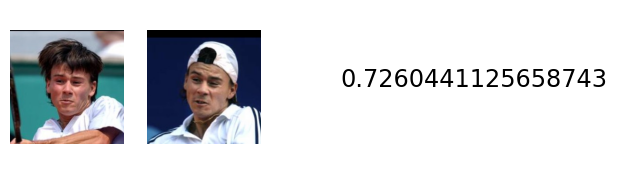

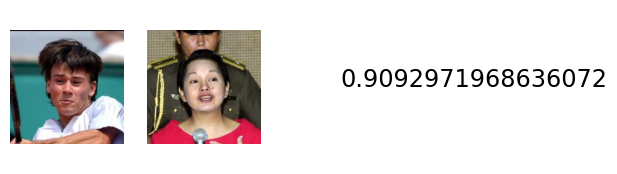

In [20]:
#Visualization of accuracy between images

help_graph.distance_visualize(image_batches[0][0], 
                   image_batches[0][1], 
                   help_calc.calculate_pair_accuracy(feature_vectors, 0, 0, 0, 1, threshold=best_threshold))
help_graph.distance_visualize(image_batches[0][0], 
                   image_batches[1][0], 
                   help_calc.calculate_pair_accuracy(feature_vectors, 0, 0, 1, 0, threshold=best_threshold))

In [21]:
accuracy = help_calc.calculate_pairs_accuracy([[0, 0, 0, 1], [0, 0, 1, 0]], feature_vectors, threshold=best_threshold)
print('Cumulative accuracy for two images above is', accuracy)

Cumulative accuracy for two images above is 0.8227883827618077


In [22]:
# Getting accuracy
print('Total accuracy is', help_calc.calculate_pairs_accuracy(pairs, feature_vectors, threshold=best_threshold))
print('Total binary accuracy is', help_calc.calculate_pairs_binary_accuracy(pairs, feature_vectors, threshold=best_threshold))

Total accuracy is 0.8165796490536451
Total binary accuracy is 0.9729437229437229


# Saving the feature vector data to the CSV file

In [26]:
def form_row_csv(feature_vectors, person_id, image_id):
    """
    Returns an array that corresponds to a single row in the csv file
    """
    
    row = [person_id, image_id]
    return np.append(row, feature_vectors[person_id][image_id])

def form_rows_csv(feature_vectors):
    """
    Returns an array with rows used to load the csv file
    """
    
    rows = []
    for person_id in range(len(feature_vectors)):
        for image_id in range(len(feature_vectors[person_id])):
            rows.append(form_row_csv(feature_vectors, person_id, image_id))
            
    return rows

def form_header_csv(vector_dimension):
    """
    Forms a header for the CSV file
    
    Input:
    vector_dimension -- integer that represents the dimensionality of the vector
    """
    
    header = ['person_id', 'image_id']
    for vector_id in range(vector_dimension):
        header.append('feature_' + str(vector_id))
        
    return header

In [17]:
import csv

# Load the CSV file
with open('output/keras_facenet_feature_vectors.csv', 'w') as dataset:
    # Create a writer
    writer = csv.writer(dataset)
    
    # Write a header
    vector_dimension = len(feature_vectors[0][0])
    writer.writerow(form_header_csv(vector_dimension))
    
    # Write rows
    writer.writerows(form_rows_csv(feature_vectors))

# Section 4. Binary string formation 

Suppose we would like to form a binary string $s(I)=s_1s_2\dots s_k$ from a feature vector $\mathbf{f}(I) \in \mathbb{R}^{k}$ of some image $I$:
$$
\mathbf{f}(I) = \begin{bmatrix} f(I)_1 \\ f(I)_2 \\ \dots \\ f(I)_k \end{bmatrix}
$$

Then, we will form the binary string according to the following rule:
$$
s_j = \begin{cases} 1, f(I)_j > 0 \\ 0, f(I)_j \leq 0 \end{cases}
$$

Also we will denote the distance between two binary string $s=s_1s_2\dots s_k$ and $h=h_1h_2 \dots h_k$ as follows:
$$
\delta(s, h) = \frac{1}{k} \sum_{j=1}^k |s_j - h_j|
$$

The similarity of two binary string we will denote as $\sigma(s, h) = 1 - \delta(s,h)$

In [23]:
# Forming the string batches from the feature vectors
string_batches = help_binary.form_string_batches(feature_vectors)

Using the set of pairs formed before, we can split it into the set of pairs with the same people and with different people (each of size $n_p' = n_p/2$). To get the average similarity between two same or different people, we will simple average the similarity function applied to each pair in the corresponding set, that is:
$$
\sigma_{\text{same/different}} = \frac{1}{n_p'}\sum_{t=1}^{n_p'} \sigma(I_{i_1^{[t]}}^{(n_1^{[t]})}, I_{i_2^{[t]}}^{(n_2^{[t]})})
$$

In [25]:
same_pairs, different_pairs = help_shaper.split_pairs(pairs)

print('Average similarity between same person', help_binary.get_average_similarity(string_batches, same_pairs))
print('Average similarity between different people', help_binary.get_average_similarity(string_batches, different_pairs))

Average similarity between same person 0.7567809794372294
Average similarity between different people 0.5120569534632035


Now define the rule of forming binary string as follows:
$$
s(\textbf{f},\gamma) = 
\begin{cases}
1, \textbf{f}_j \geq \gamma \\ 
0, \textbf{f}_j < \gamma
\end{cases}, \; j = \overline{1,k}, \; \gamma \in \mathbb{R}
$$

We defined similarity between feature vectors $\textbf{f}$ and $\textbf{g}$ as follows:
$$
\sigma(\textbf{f},\textbf{g},\gamma) = 1 - \frac{1}{k}\sum_{j=1}^k |s(\textbf{f},\gamma)_j - s(\textbf{g},\gamma)_j|
$$

Suppose we have the set of string batches of the same people $\mathcal{P}_{\text{same}}$ and of different people $\mathcal{P}_{\text{diff}}$ where $\mathcal{P}_{\text{same}} \cup \mathcal{P}_{\text{diff}} = \mathcal{P}$. Average similarity is:
$$
\sigma_{\text{same}}(\mathcal{P},\gamma) = \frac{1}{|\mathcal{P}_{\text{same}}|}\sum_{\textbf{f},\textbf{g} \in \mathcal{P}_{\text{same}}} \sigma(\textbf{f},\textbf{g},\gamma)
$$
$$
\sigma_{\text{diff}}(\mathcal{P},\gamma) = \frac{1}{|\mathcal{P}_{\text{diff}}|}\sum_{\textbf{f},\textbf{g} \in \mathcal{P}_{\text{diff}}} \sigma(\textbf{f},\textbf{g},\gamma)
$$

We would like to choose $\gamma=\widetilde{\gamma}$ such that:
$$
\widetilde{\gamma} = \text{argmax}_{\gamma}(\sigma_{\text{same}}(\mathcal{P},\gamma) - \sigma_{\text{diff}}(\mathcal{P},\gamma)) 
$$

In [28]:
def form_binary_string_with_offset(feature_vector, offset=0.0):
    """
    Function that forms the binary string according to the rule described above
    """

    binary_string = ''
    for vector_element in feature_vector:
        binary_string += ('0' if vector_element <= offset else '1')

    return binary_string

def form_string_batches_with_offset(feature_vectors, offset=0.0):
    """
    Function that converts the feature vector batches to the string batches

    Input:
    feature_vectors -- array of feature vectors batches

    Output:
    string_batches -- array of string batches of the same shape as feature_vectors array
    """

    string_batches = []

    for batch in feature_vectors:
        string_batch = []
        for feature_vector in batch:
            string_batch.append(form_binary_string_with_offset(feature_vector, offset))

        string_batches.append(string_batch)

    return string_batches

In [33]:
# Forming the string batches from the feature vectors using some test_offset
test_offset=0.2
string_batches_offset = form_string_batches_with_offset(feature_vectors,offset=test_offset)

same_pairs, different_pairs = help_shaper.split_pairs(pairs)

print('Average similarity between same person', help_binary.get_average_similarity(string_batches_offset, same_pairs))
print('Average similarity between different people', help_binary.get_average_similarity(string_batches_offset, different_pairs))

Average similarity between same person 0.7644243777056277
Average similarity between different people 0.5231669372294372


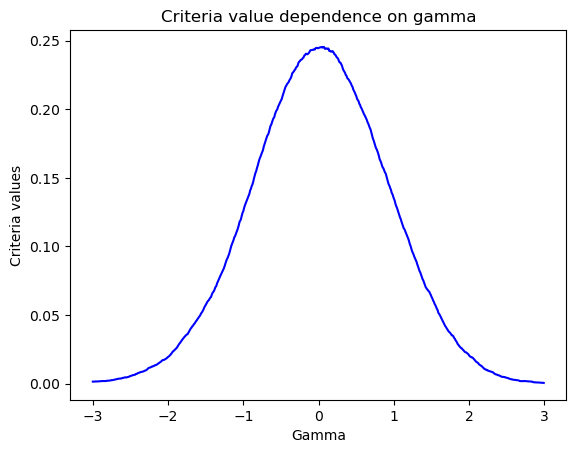

In [34]:
def criteria_value(offset=0.0):
    string_batches_offset = form_string_batches_with_offset(feature_vectors,offset)
    same_pairs, different_pairs = help_shaper.split_pairs(pairs)
    return help_binary.get_average_similarity(string_batches_offset, same_pairs) - help_binary.get_average_similarity(string_batches_offset, different_pairs)

gammas = np.arange(-3, 3, 0.01)
criteria_values = [criteria_value(offset=gamma) for gamma in gammas]

help_graph.draw_plot(gammas, criteria_values,
                     X_label='Gamma', Y_label='Criteria value', 
                     title='Criteria value dependence on gamma', color='blue')

In [1]:
max_criteria_value = np.max(criteria_values)
max_gamma = 0.0

for k in range(len(criteria_values)):
    if criteria_values[k] == max_criteria_value:
        max_gamma = gammas[k]

string_batches_offset = form_string_batches_with_offset(feature_vectors,max_gamma)
        
print('Most optimal value of gamma is {}'.format(max_gamma))
print('In that case criteria value is {}'.format(max_criteria_value))
print('Average similarity between same people is {}'.format(help_binary.get_average_similarity(string_batches_offset, same_pairs)))
print('Average similarity between different people is {}'.format(help_binary.get_average_similarity(string_batches_offset, different_pairs)))

NameError: name 'np' is not defined